**Software for calculation of sample mass thickness for quantitative XRF analysis**

*Filip Jan Baran* (fjbaran@student.agh.edu.pl)

Supervisor: dr inż. Paweł Wróbel

Faculty of Physics and Applied Computer Science

AGH University of Science and Technology

Kraków 2024

---

*Importing libraries:*

In [ ]:
import math
import scipy.integrate as integrate
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import xraylib as xrl

*Configuration of measurement and specimen composition:*

`config.txt` reading:

In [2]:
# config.txt content:
# PSI_IN [deg]
# PSI_OUT [deg]
# THICK_DEF [-]
# CALC_RANGE [-] (fraction of decade in log10 scale)
# CALC_ITERATIONS [-]
# DENSITY [g/cm2] (optional)

file = open("config.txt", "r")
PSI_IN = math.radians(float(file.readline())) # [rad]
PSI_OUT = math.radians(float(file.readline())) # [rad]
THICK_DEF = float(file.readline()) # [-]
CALC_RANGE = float(file.readline()) # [-]
CALC_ITERATIONS = int(file.readline()) # [-]
try: DENSITY = float(file.readline()) # [g/cm3]
except: DENSITY = float("NaN")
file.close()

`beam.txt` reading:

In [3]:
# beam.txt content:
# (like in Rh_tube_100eV.txt)
# energy_0 \t bremsstrahlung_intensity_0
# energy_1 \t bremsstrahlung_intensity_1
# :
# energy_n \t bremsstrahlung_intensity_n=0
# energy_specific_line_0 \t specific_line_intensity_0
# energy_specific_line_1 \t specific_line_intensity_1
# :
# energy_specific_line_m \t specific_line_intensity_m

temp = np.asarray(np.genfromtxt("beam.txt"))
res = temp[1, 0] - temp[0, 0] # [keV]
bremsstrahlung = True
bremsstrahlung_n = 0
for i in range(temp.shape[0]):
    if(not bremsstrahlung):
        for j in range(bremsstrahlung_n):
            if(abs(I0_REF[j, 0] - temp[i, 0]) <= res / 2):
                I0_REF[j, 1] += temp[i, 1]
    if(temp[i, 1] == 0): 
        bremsstrahlung = False
        bremsstrahlung_n = i
        I0_REF = temp[:bremsstrahlung_n, :] # [keV, counts]
        for j in range(bremsstrahlung_n):
            I0_REF[j, 1] *= res

`input.txt` reading:

In [20]:
# input.txt content:
# compound_0 \t mass_fraction_0
# compound_1 \t mass_fraction_1
# :
# compound_n \t mass_fraction_n

name = "(C$_{10}$H$_8$O$_4$)$_n$"
INPUT = np.genfromtxt(name + "/input.txt", dtype = "U64, f", ndmin = 1)
# INPUT = np.genfromtxt("input.txt", dtype = "U64, f", ndmin = 1)
mF = 0 # [-]
eps = 1e-4 # [-]
for i in range(INPUT.size):
    mF += INPUT[i][1]
if(mF == 0):
    mF = float(INPUT.size)
    for i in range(INPUT.size):
        INPUT[i][1] = 1
if(abs(mF - 1) > eps):
    print(f"Sum of mass fractions is {mF:.2}, which is not 1! They will be normalized.")
Elements = np.zeros((118, 2))
for i in range(118): 
    Elements[i, 0] = i + 1
for i in range(INPUT.size):
    compound = xrl.CompoundParser(INPUT[i][0])
    for j in range(len(compound['Elements'])):
        Elements[compound['Elements'][j] - 1, 1] += compound['massFractions'][j] * INPUT[i][1] / mF
to_delete = []
for i in range(118):
    if(Elements[i, 1] == 0):
        to_delete.append(i)
Elements = np.delete(Elements, to_delete, 0) # [-, -]

Configuration check:

PSI_IN = 0.7853981633974483 rad = 45.0 deg,
PSI_OUT = 0.7853981633974483 rad = 45.0 deg,
CALC_RANGE = 0.4 (in log scale),
CALC_ITERATIONS = 50,
THICK_DEF = 0.99,
DENSITY = 1.0
Elements =
 [[1.         0.04204392]
 [6.         0.62493496]
 [8.         0.33302113]]


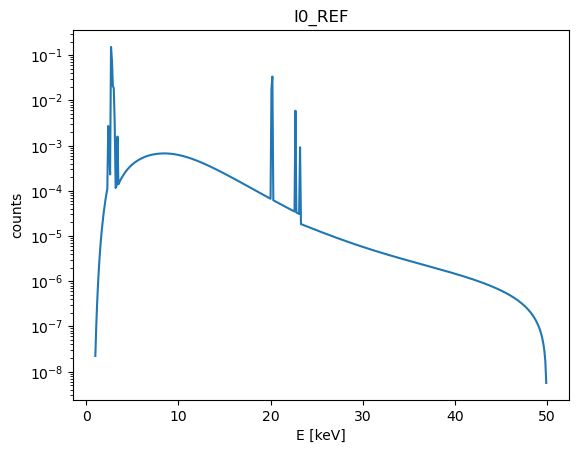

In [21]:
print(f"PSI_IN = {PSI_IN} rad = {math.degrees(PSI_IN)} deg,\nPSI_OUT = {PSI_OUT} rad = {math.degrees(PSI_OUT)} deg,\nCALC_RANGE = {CALC_RANGE} (in log scale),\nCALC_ITERATIONS = {CALC_ITERATIONS},\nTHICK_DEF = {THICK_DEF},\nDENSITY = {DENSITY}")

plt.figure()
plt.plot(I0_REF[:, 0], I0_REF[:, 1])
plt.yscale("log")
plt.xlabel("E [keV]")
plt.ylabel("counts")
plt.title("I0_REF")

print(f"Elements =\n {Elements}")

*Usage of `xraylib` library:*

In [6]:
def Eabs(Z, shell):
    try: return xrl.EdgeEnergy(Z, shell) # [keV]
    except: return 0

def E(Z, line):
    try: return xrl.LineEnergy(Z, line) # [keV]
    except: return 0

def sigma(Z, line, E):
    try: return xrl.CS_FluorLine(Z, line, E) # [cm2/g]
    except: return 0

def mu(E):
    mu = 0
    for element in Elements:
        Z = int(element[0])
        try: temp = xrl.CS_Total(Z, E)
        except: temp = float("NaN")
        mu += temp * element[1] if np.isfinite(temp) else 0
    return mu # [cm2/g]

def line_to_shell(line):
    if line > 3:
        return float("NaN")
    elif line == 3:
        return xrl.L2_SHELL
    elif line == 2:
        return xrl.L3_SHELL
    elif line >= -29:
        return xrl.K_SHELL
    elif line >= -58:
        return xrl.L1_SHELL
    elif line >= -85:
        return xrl.L2_SHELL
    elif line >= -113:
        return xrl.L3_SHELL
    elif line >= -136:
        return xrl.M1_SHELL
    elif line >= -158:
        return xrl.M2_SHELL
    elif line >= -180:
        return xrl.M3_SHELL
    elif line >= -200:
        return xrl.M4_SHELL
    elif line >= -219:
        return xrl.M5_SHELL
    elif line >= -237:
        return xrl.N1_SHELL
    elif line >= -254:
        return xrl.N2_SHELL
    elif line >= -270:
        return xrl.N3_SHELL
    elif line >= -285:
        return xrl.N4_SHELL
    elif line >= -299:
        return xrl.N5_SHELL
    elif line >= -312:
        return xrl.N6_SHELL
    elif line >= -324:
        return xrl.N7_SHELL
    elif line >= -335:
        return xrl.O1_SHELL
    elif line >= -345:
        return xrl.O2_SHELL
    elif line >= -354:
        return xrl.O3_SHELL
    elif line >= -362:
        return xrl.O4_SHELL
    elif line >= -369:
        return xrl.O5_SHELL
    elif line >= -372:
        return xrl.O6_SHELL
    elif line >= -374:
        return xrl.O7_SHELL
    elif line >= -378:
        return xrl.P1_SHELL
    elif line >= -381:
        return xrl.P2_SHELL
    elif line >= -383:
        return xrl.P3_SHELL
    else:
        return float("NaN")

*Simplified approaches implementation:*

In [7]:
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()

I0 = lambda E : I0_REF[find_nearest_index(I0_REF[:, 0], E), 1] # [counts]

def Eeff(Z, line):
    nominator = lambda E : I0(E) * sigma(Z, line, E) * E # [counts * cm2/g * keV]
    denominator = lambda E : I0(E) * sigma(Z, line, E) # [counts * cm2/g]
    try: return integrate.quad(nominator, 0, I0_REF[-1, 0])[0] / integrate.quad(denominator, 0, I0_REF[-1, 0])[0] # [keV]
    except: return float("NaN")

def surface_mass_simplified(Z, line, type = 'A'):
    shell = line_to_shell(line)
    simplification = lambda type : Eabs(Z, shell) if type == 'A' else Eeff(Z, line) # [keV]
    if simplification(type) > I0_REF[-1, 0] or np.isnan(simplification(type)):
        return float("NaN")
    try: return -np.log(1 - THICK_DEF) / ( mu(simplification(type)) / math.sin(PSI_IN) + mu(E(Z, line)) / math.sin(PSI_OUT) ) # [g/cm2]
    except: return float("NaN")

`Eeff` calculation check for specific `Lines`, `Labels` and `Colors`:

In [ ]:
# Lines = [xrl.KA_LINE, xrl.KB_LINE, xrl.LA_LINE, xrl.LB_LINE]
Labels = [r'$K_\alpha$', r'$K_\beta$', r'$L_\alpha$', r'$L_\beta$']
Lines = [xrl.KA_LINE, xrl.LA_LINE]
Labels = [r'$K_\alpha$', r'$L_\alpha$']
Colors = ['blue', 'orange', 'green', 'red']

teff = np.zeros((98, len(Lines)))
tabs = np.zeros((98, len(Lines)))
for line in range(len(Lines)):
    for Z in range(1, 99):
        teff[Z - 1, line] = Eeff(Z, Lines[line])
        tabs[Z - 1, line] = Eabs(Z, line_to_shell(Lines[line]))
        
# plt.figure()
# for line in range(len(Lines)):
#     plt.plot(range(1, 99), teff[:, line], '*', label = Labels[line], color = Colors[line])
# for line in range(len(Lines)):
#     plt.plot(range(1, 99), tabs[:, line], '.', color = Colors[line])
# plt.legend()
# plt.xlabel("Z")
# plt.ylabel("E [keV]")
# plt.title("Eeff (stars), Eabs (points)")
# try: plt.ylim([0, 1.1 * np.nanmax(teff[:, 0])])
# except: plt.ylim([0, I0_REF[-1, 0]])

fig, ax = plt.subplots()
double_column_size = 17.1 # [cm]
single_column_size = 8.3 # [cm]
# fig.set_size_inches((double_column_size / 2.54, double_column_size / 3 / 2.54))
fig.set_size_inches((single_column_size / 2.54, single_column_size / 1.5 / 2.54))

# fig.suptitle(f"{name}")

for line in range(len(Lines)):
    ax.plot(range(1, 99), teff[:, line], '.', markersize = 2, label = Labels[line])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel(r"Atomic number")
ax.set_xlim([0, 100])
ax.set_ylabel(r"Effective energy [keV]")
ax.tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True, bottom = True, left = True) 
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.1, box.width * 0.9, box.height * 0.9])  

ax.text(45, 40, r"K$\alpha$", ha = 'center', va = 'center')
ax.text(90, 25, r"L$\alpha$", ha = 'center', va = 'center')

# fig.savefig(f"tiff/effective-energy.tiff", dpi = 1000)
# fig.savefig(f"pdf/effective-energy.pdf", dpi = 1000)
# fig.savefig(f"png/effective-energy.png", dpi = 1000)

C:\Users\pfili\AppData\Local\Temp\ipykernel_20116\2378315348.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  try: return integrate.quad(nominator, 0, I0_REF[-1, 0])[0] / integrate.quad(denominator, 0, I0_REF[-1, 0])[0] # [keV]


*Exact approach implementation:*

In [11]:
def surface_mass(Z, line):
    shell = line_to_shell(line)
    nominator = lambda E0 : I0(E0) * sigma(Z, line, E0) / ( mu(E0) / math.sin(PSI_IN) + mu(E(Z, line)) / math.sin(PSI_OUT) ) * (1 - np.exp(-sm * ( mu(E0) / math.sin(PSI_IN) + mu(E(Z, line)) / math.sin(PSI_OUT) )))
    # [counts * cm2/g * g/cm2 * (1 - exp([sm] * cm2/g)] = [counts] => [sm] = [g/cm2]
    denominator = lambda E0 : I0(E0) * sigma(Z, line, E0) / ( mu(E0) / math.sin(PSI_IN) + mu(E(Z, line)) / math.sin(PSI_OUT) )
    # [counts * cm2/g * g/cm2] = [counts]
    sm_simplified = surface_mass_simplified(Z, line) # [g/cm2]
    if np.isfinite(sm_simplified):
        sm_range = np.logspace(-CALC_RANGE, CALC_RANGE, 2) * sm_simplified # [g/cm2]
        for i in range(CALC_ITERATIONS):
            if(sm_range[1] - sm_range[0] < 1e-8):
                break
            sm = stats.uniform(sm_range[0], sm_range[1] - sm_range[0]).rvs() # [g/cm2]
            try: integral = integrate.quad(nominator, Eabs(Z, shell), I0_REF[-1, 0])[0] / integrate.quad(denominator, Eabs(Z, shell), I0_REF[-1, 0])[0] # [-]
            except: return float("NaN")
            if(integral < THICK_DEF):
                sm_range[0] = sm
            else:
                sm_range[1] = sm
        return sm_range[1] # [g/cm2]
    return float("NaN")

Check results for simple element `Z` and `line`:

In [ ]:
Z = 34
line = xrl.KA_LINE

A = surface_mass_simplified(Z, line, 'A')
B = surface_mass_simplified(Z, line, 'B')
C = surface_mass(Z, line)
print(f"\nSimplification A: {A} g/cm2\nSimplification B: {B} g/cm2\nExact approach (C): {C} g/cm2\n")
print(f"Relative difference between approaches A and C: {(A-C)/C*100} %\nRelative difference between approaches B and C: {(B-C)/C*100} %\n")

C:\Users\pfili\AppData\Local\Temp\ipykernel_20116\2378315348.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  try: return integrate.quad(nominator, 0, I0_REF[-1, 0])[0] / integrate.quad(denominator, 0, I0_REF[-1, 0])[0] # [keV]
C:\Users\pfili\AppData\Local\Temp\ipykernel_20116\3596319720.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, disco


Simplification A: 0.10773931151117754 g/cm2
Simplification B: 0.14560720356609438 g/cm2
Exact approach (C): 0.14864998729294593 g/cm2

Relative difference between approaches A and C: -27.521479501471696 %
Relative difference between approaches B and C: -2.0469451644520507 %



Generate results for specific `Lines`:

It may take several minutes to execute!

In [ ]:
Lines = [xrl.KA_LINE, xrl.LA_LINE]

OUTPUT = [np.zeros((98, 4)) for _ in range(len(Lines))]
OUTPUT = np.stack(OUTPUT, axis = 0)
for i in range(10):
    for line in range(len(Lines)):
        for Z in range(1, 99):
            OUTPUT[line, Z - 1, 0] = Z
            OUTPUT[line, Z - 1, 1] = surface_mass_simplified(Z, Lines[line], 'A')
            OUTPUT[line, Z - 1, 2] = surface_mass_simplified(Z, Lines[line], 'B')
            OUTPUT[line, Z - 1, 3] = surface_mass(Z, Lines[line])

C:\Users\pfili\AppData\Local\Temp\ipykernel_20116\2378315348.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  try: return -np.log(1 - THICK_DEF) / ( mu(simplification(type)) / math.sin(PSI_IN) + mu(E(Z, line)) / math.sin(PSI_OUT) ) # [g/cm2]
C:\Users\pfili\AppData\Local\Temp\ipykernel_20116\3596319720.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  try: integral = integrate.quad(nominator, Eabs(Z, shell), I0_REF[-1, 0])[0] / integrate.quad(denominator, Eabs(Z, shell), I0_REF[-1, 0])[0] # [-]


Generate `output.txt` for specific `Labels`:

Length of `Labels` have to be the same as `Lines` in the code above!

In [29]:
Labels = ["Ka", "La"]

# name = "Portland Cement"

file = open(name + "/output.txt", "w")
# for fname in ["config.txt", "input.txt"]:
#     file_input = open(fname, "r")
#     txt = file_input.readlines()
#     for t in txt:
#         file.write(t)
#     file.write("\n")
#     file_input.close()
file.write("Z")
for line in range(len(Labels)):
    if np.isnan(DENSITY):
        file.write(f"\t{Labels[line]} [g/cm2] A\t{Labels[line]} [g/cm2] B\t{Labels[line]} [g/cm2] C")
    else:
        file.write(f"\t{Labels[line]} [um] A\t{Labels[line]} [um] B\t{Labels[line]} [um] C")
file.write("\n")
for Z in range(1, 99):
    file.write(f"{Z}")
    for line in range(len(Labels)):
        if np.isnan(DENSITY):
            file.write(f"\t{OUTPUT[line, Z-1, 1]}\t{OUTPUT[line, Z-1, 2]}\t{OUTPUT[line, Z-1, 3]}")
        else:
            file.write(f"\t{OUTPUT[line, Z-1, 1] / DENSITY * 1e4}\t{OUTPUT[line, Z-1, 2] / DENSITY * 1e4}\t{OUTPUT[line, Z-1, 3] / DENSITY * 1e4}")
    file.write("\n")
file.close()

Generate results plot for specific `Labels`:

Length of `Labels` have to be the same as `Lines` in the code above!

(0.0, 100.0)

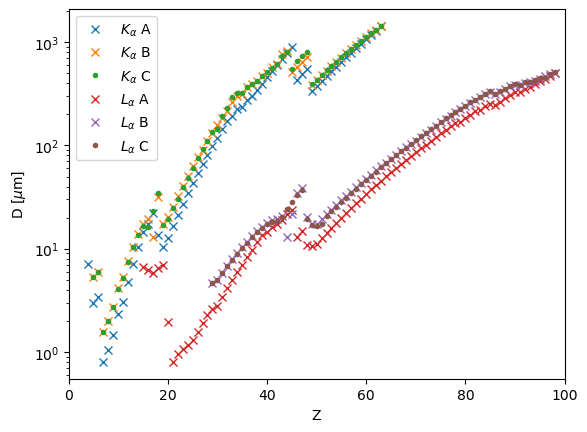

In [13]:
Labels = [r'$K_\alpha$', r'$L_\alpha$']

plt.figure()
for line in range(len(Labels)):
    if np.isnan(DENSITY):
        plt.plot(OUTPUT[line, :, 0], OUTPUT[line, :, 1], 'x', label=f"{Labels[line]} A")
        plt.plot(OUTPUT[line, :, 0], OUTPUT[line, :, 2], 'x', label=f"{Labels[line]} B")
        plt.plot(OUTPUT[line, :, 0], OUTPUT[line, :, 3], '.', label=f"{Labels[line]} C")
    else:
        plt.plot(OUTPUT[line, :, 0], OUTPUT[line, :, 1] / DENSITY * 1e4, 'x', label=f"{Labels[line]} A")
        plt.plot(OUTPUT[line, :, 0], OUTPUT[line, :, 2] / DENSITY * 1e4, 'x', label=f"{Labels[line]} B")
        plt.plot(OUTPUT[line, :, 0], OUTPUT[line, :, 3] / DENSITY * 1e4, '.', label=f"{Labels[line]} C")
plt.yscale("log")
plt.xlabel("Z")
if np.isnan(DENSITY):
    plt.ylabel(r"$\rho$D [g/cm$^2$]")
else:
    plt.ylabel(r"D [$\mu$m]")
plt.legend()
plt.xlim([0, 100])

*Clear all variables and results:*

Confirmation is required!

In [ ]:
%reset